# **IMPORT DATA**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Input

from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


In [8]:
#PATH
rootPath = "/content/drive/MyDrive/Colab Notebooks/abnormal-detection/"
#read datafile
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/abnormal-detection/cleanedDataset/allinOneInput.csv")
print(df.head())

   Dst Port  Protocol    Timestamp  ...  Idle Max  Idle Min             Label
0       445         6  571928241.0  ...         0         0            Benign
1     50467         6  572610244.0  ...         0         0            Benign
2      3389         6  571896957.0  ...         0         0            Benign
3        80         6  572060813.0  ...         0         0  DoS attacks-Hulk
4     48914         6  572060830.0  ...         0         0            Benign

[5 rows x 80 columns]


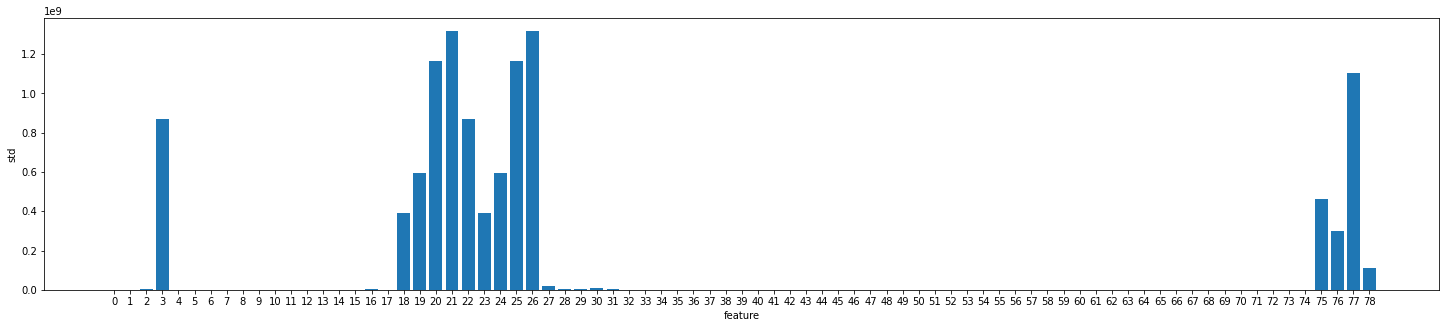

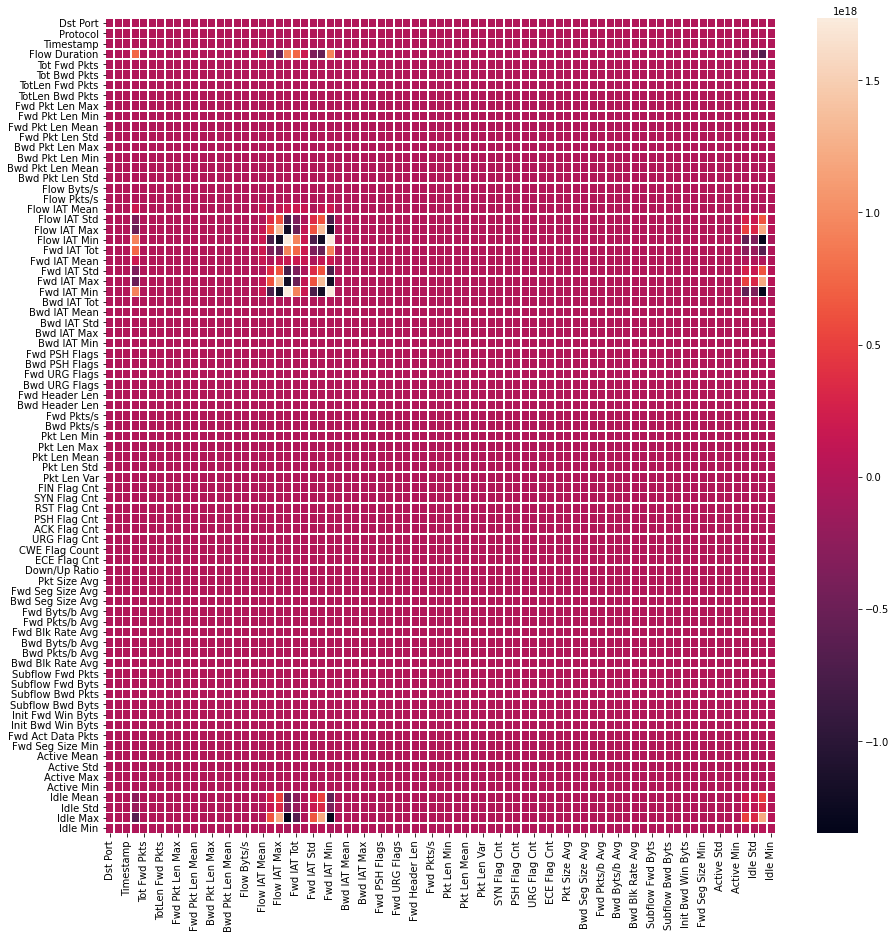

In [ ]:
#@title Visualize data
fig, ax = plt.subplots(figsize=(25,5))  

#bar std
std = df.std()
plt.bar(range(len(std)), std)
plt.xlabel("feature")
plt.ylabel("std")
plt.xticks(range(len(std)))
plt.show()
#use heatmap
covMatrix = pd.DataFrame.cov(df)
fig, ax = plt.subplots(figsize=(15,15)) 
sn.heatmap(covMatrix, linewidths= 0.5, ax=ax)
plt.show()

# PREPROCESSING DATASET

In [4]:
def filtering_data(df, encoder, is_filter=True):
  '''Choose features which has high std
  Args:
    df(dataframe) : training data
    encoder(LabelEncoder)
    is_filter(bool): turn on/off filtering features
  Return: 
    dummies_labels
    filtered_features
  '''
  #extract label and encode
  data_labels = encoder.fit_transform(df.pop('Label'))
  dummies_labels = to_categorical(data_labels)
  #standard feature
  if is_filter:
    df = df.drop('Timestamp', axis=1)
    filtered_features = df[[col for col in df if df[col].std() > 1]]
  else:
    filtered_features = df
  
  return dummies_labels, filtered_features

# **BUILD THE MODEL**

In [5]:
#@title Creat-new-model function
def create_new_model(input_shape, output_shape=1, 
                     optimizer='adam', loss='categorical_crossentropy', 
                     nneural=[100, 200], dropout=0.01):
  '''creat a baseline Sequential model 

  Args:
    input_shape(tuple(int,int)) : demension dataframe with format (col, row)
    output_shape(int) : numbers label unique
    optimizer(str, optional) 
    loss(str, optional)
    nneural(list(int), option) : number layer and node neural respectly
                                -1 for BatchNormalization
    dropout(float) : ratio of weights drop out last output layer

  Return:
    a model
  '''
  model = Sequential()
  model.add(Input(shape=(input_shape,)))

  for item in nneural:
    #make normalization layer
    if item == -1:
      model.add(BatchNormalization())
    elif item > 0:
      model.add(Dense(item, activation='relu'))

  #make drop out
  model.add(Dropout(dropout))
  #make output layer
  model.add(Dense(output_shape, activation='softmax'))

  #compile
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  return model

In [ ]:
#@title experiment function
def experiment(features_data, labels_data, model, epochs=10, batch_size=10):
  '''Trail and test custom model

  Args:
    features_data(dataframe) : features datas
    labels_data(encode dataframe): labels
    model(keras model) : neural network model
    epochs(int, optional) : number of epochs
    batch_size(int) : size of data batch

  Return
    model(Keras Neural Netwok model) : a model has been trained
    history : history during training processing
  '''
  #split dataset
  np.random.seed(1)
  X_train, X_test, y_train, y_test = train_test_split(features_data, labels_data, test_size=0.3, random_state=np.random.randint(100))

  # Instantiate a model checkpoint callback
  model_save = ModelCheckpoint(rootPath + 'model/best_model.hdf5', save_best_only=True)
  early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=4)
  #fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                      validation_data=(X_test, y_test),
                      callbacks=[early_stopping_monitor, model_save],
                      verbose=2)

  #evaluate model
  score = model.evaluate(X_test, y_test)
  print("Evaluate\t acc : {}, loss : {}".format(score[0], score[1]))

  return history

  

# EXCUTE

In [6]:
#@title ploting history function
def plot_history(history, title=""):
  '''ploting accuracay and loss graph in history of traing model

    Args:
      history(dict) 
      title(str, option)
  '''
  # Plot train vs test accuracy per epoch
  plt.figure()
  # Use the history metrics
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])

  plt.title('Model accuracy ' + title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train','Test'])
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model accuracy ' + title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train','Test'])
  plt.show()

In [9]:
#@title Preprocessing data
encoder = LabelEncoder()
is_filter = True
labels, features = filtering_data(df, encoder, is_filter)
features = normalize(features.values)
del df #limit ram

In [11]:
#@title Make a model
#encode and normalize data
output_shape = len(encoder.classes_)
input_shape = len(features[0])
print("input_shape = (", input_shape, ", ) \noutput_shape = ", output_shape)
  
#Instance model with filtered_data
model = create_new_model(input_shape, output_shape, nneural=[100,-1, 250,-1], dropout=0.25)
print("----summary model----\n", model.summary())

input_shape = ( 59 , ) 
output_shape =  12
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               6000      
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 250)               25250     
_________________________________________________________________
batch_normalization_1 (Batch (None, 250)               1000      
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                3012      
Total params: 35,662
Trainable params: 34,962
Non-trainable params: 700
_______

In [ ]:
history = experiment(features,labels, model, epochs=100, batch_size=15)
plot_history(history, "with filter")

# Tuning hyperparameter

In [12]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

model = KerasClassifier(build_fn=create_new_model, epochs=15)

params = dict(optimizer=['adam'], batch_size=[10, 15, 20], dropout=[0.1, 0.2, 0.25],
              nneural=[[input_shape, 200, -1],
                       [input_shape,-1, 200, -1],
                       [100, -1, 250, -1, 150,-1]],
              input_shape=[input_shape], output_shape=[output_shape])
random_search_model = RandomizedSearchCV(model, param_distributions=params, cv=5)

In [ ]:
print(features.shape)
random_search_result = random_search_model.fit(features, labels)
print("Best: %f score -> using %s".format(random_search_result.best_score_, 
                                          random_search_result.best_params_))

(5225413, 59)
Epoch 1/15
278689/278689 [==============================] - 505s 2ms/step - loss: 0.1060 - accuracy: 0.9575
Epoch 2/15
278689/278689 [==============================] - 505s 2ms/step - loss: 0.0598 - accuracy: 0.9735
Epoch 3/15
278689/278689 [==============================] - 502s 2ms/step - loss: 0.0559 - accuracy: 0.9751
Epoch 4/15
278689/278689 [==============================] - 525s 2ms/step - loss: 0.0541 - accuracy: 0.9758
Epoch 5/15
278689/278689 [==============================] - 493s 2ms/step - loss: 0.0531 - accuracy: 0.9761
Epoch 6/15
278689/278689 [==============================] - 434s 2ms/step - loss: 0.0523 - accuracy: 0.9764
Epoch 7/15
278689/278689 [==============================] - 436s 2ms/step - loss: 0.0515 - accuracy: 0.9767
Epoch 8/15
278689/278689 [==============================] - 444s 2ms/step - loss: 0.0513 - accuracy: 0.9766
Epoch 9/15
278689/278689 [==============================] - 463s 2ms/step - loss: 0.0508 - accuracy: 0.9767
Epoch 10/15
27